In [1]:
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D
from pickle import dump,load
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.models import load_model

Using TensorFlow backend.
/home/sid/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sid/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sid/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sid/.local/lib/python3.7/site-packages/tensorflow/python/framework/d

In [2]:
def read_file(filepath):
	with open(filepath) as f:
		str_text = f.read()
	return str_text

In [3]:

text = read_file('./machado_preprocessed.txt')
tokens = text.split(" ")
#  tokens.pop(0)

In [4]:
train_len = 10
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

In [5]:
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1
        

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences) 

#Collecting some information   
unique_words = tokenizer.index_word
unique_wordsApp = tokenizer.word_counts
vocabulary_size = len(tokenizer.word_counts)

In [7]:
n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

In [8]:
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]

train_targets = to_categorical(train_targets, num_classes=vocabulary_size+1)
seq_len = train_inputs.shape[1]
train_inputs.shape

(44425, 9)

In [9]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, seq_len,input_length=seq_len))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(vocabulary_size,activation='softmax'))
    opt_adam = optimizers.adam(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=opt_adam,metrics=['accuracy'])
    model.summary()
    return model

In [10]:
dump(tokenizer,open('machado_tokenizer_Model4','wb'))


In [11]:
model = create_model(vocabulary_size+1,seq_len)
path = './checkpoints/word_pred_Model4.h5'
checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_inputs,train_targets,batch_size=128,epochs=40,verbose=1,callbacks=[checkpoint], validation_split=0.33)
model.save('machado_modell4.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 9)              11547     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 9, 9)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               272384    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              257000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1283)              1284283   
Total params: 1,825,214
Trainable params: 1,825,214
Non-trainable params: 0
____________________________________________

29764/29764 [==============================] - 23s 775us/step - loss: 4.9930 - accuracy: 0.0862 - val_loss: 6.3182 - val_accuracy: 0.0758

Epoch 00028: loss improved from 5.04576 to 4.99301, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 29/40
29764/29764 [==============================] - 22s 749us/step - loss: 4.9511 - accuracy: 0.0872 - val_loss: 6.4219 - val_accuracy: 0.0754

Epoch 00029: loss improved from 4.99301 to 4.95105, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 30/40
29764/29764 [==============================] - 26s 883us/step - loss: 4.9058 - accuracy: 0.0883 - val_loss: 6.4180 - val_accuracy: 0.0729

Epoch 00030: loss improved from 4.95105 to 4.90577, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 31/40
29764/29764 [==============================] - 31s 1ms/step - loss: 4.8541 - accuracy: 0.0884 - val_loss: 6.5112 - val_accuracy: 0.0739

Epoch 00031: loss improved from 4.90577 to 4.85407, saving model to ./checkpoints/word_pred_Model4.h5
Ep

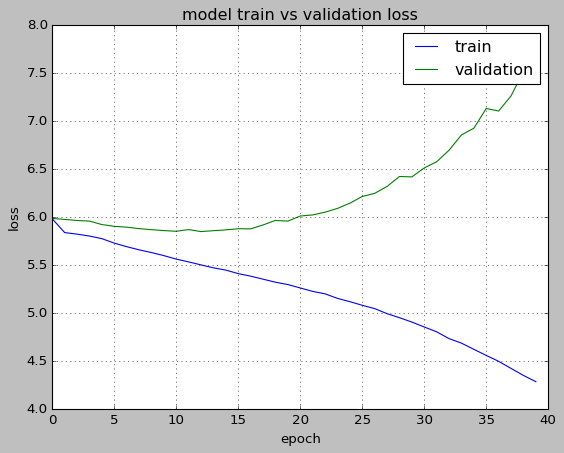

In [12]:
from matplotlib import pyplot

# history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
pyplot.style.use("classic")
pyplot.grid()
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig("validation_loss_dropout.pdf")